<a href="https://colab.research.google.com/github/hunarpreet1/TradeAnomaly/blob/main/PriceVolumneAnomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install ta
import ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=bab07746a2dd6aded9343a6c39730f697fa597a6eeff58c0693a0f33b2b89fc6
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [38]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date

folder_path = '/content/drive/My Drive/PriceData'

In [39]:
priceData = pd.read_csv(folder_path + '/' + 'pricedata.csv')
universe = pd.read_csv(folder_path + '/' + 'nse200universe.csv')
nifty50 = pd.read_csv(folder_path + '/' + 'NiftyTRI_Index.csv')
nifty200 = pd.read_csv(folder_path + '/' + 'NSE200TRI_Index.csv')

In [40]:
universe.drop("Unnamed: 0", axis=1, inplace=True)
universe.columns = pd.to_datetime(universe.columns)

In [41]:
universe.drop(200, inplace=True)

In [42]:
priceData['security'] = priceData['security'].str.replace(' IN Equity', '', regex=False)

In [43]:
universe = universe.applymap(lambda x: str(x).replace(' IS', '') if pd.notnull(x) else x)

<ipython-input-43-d19ebc0da713>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  universe = universe.applymap(lambda x: str(x).replace(' IS', '') if pd.notnull(x) else x)


In [44]:
# around 3% data has volume missing
# around 0.1% data has price missing
priceData.set_index('date', inplace=True)
nifty50.set_index('date', inplace=True)
nifty200.set_index('date', inplace=True)

priceData.index = pd.to_datetime(priceData.index)
nifty50.index = pd.to_datetime(nifty50.index)
nifty200.index = pd.to_datetime(nifty200.index)

priceData.dropna(inplace=True) # Think about Nans later.....
nifty50.fillna(method="ffill", inplace=True)
nifty50.fillna(method="bfill", inplace=True)

nifty200.fillna(method="ffill", inplace=True)
nifty200.fillna(method="bfill", inplace=True) # can fill same as PX_LAST ????

<ipython-input-44-888d5f634456>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nifty50.fillna(method="ffill", inplace=True)
<ipython-input-44-888d5f634456>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nifty50.fillna(method="bfill", inplace=True)
<ipython-input-44-888d5f634456>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nifty200.fillna(method="ffill", inplace=True)
<ipython-input-44-888d5f634456>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nifty200.fillna(method="bfill", inplace=True) # can fill same as PX_LAST ????


<Axes: xlabel='date'>

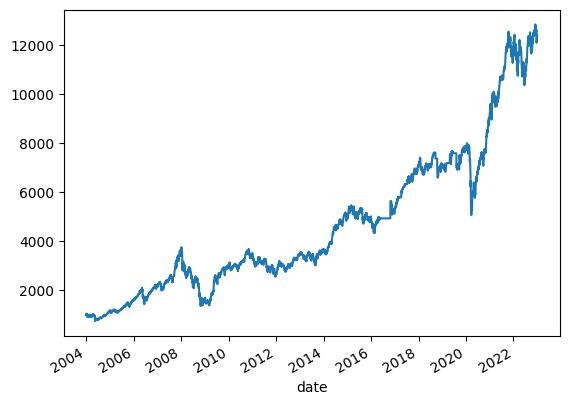

In [44]:
nifty200['PX_HIGH'].plot() # Many missing non close values

In [45]:
priceData["totalVolume"] = priceData.groupby(level=0)["PX_VOLUME"].transform("sum")
priceData["maxStockVolume"] = priceData.groupby(level=0)["PX_VOLUME"].transform("max")
priceData["volume_ratio"] = priceData["PX_VOLUME"] / priceData["totalVolume"]
priceData["volume_max_ratio"] = priceData["PX_VOLUME"] / priceData["maxStockVolume"]

# priceData['returnsOpen'] = priceData.groupby('security')['PX_OPEN'].pct_change()
# priceData['returnsClose'] = priceData.groupby('security')['PX_LAST'].pct_change()
# priceData['returnsHigh'] = priceData.groupby('security')['PX_HIGH'].pct_change()
# priceData['returnsLow'] = priceData.groupby('security')['PX_LOW'].pct_change()
#priceData.dropna(inplace=True) # Think about Nans later.....

In [46]:
import numpy as np
def add_return_features(price_df):
    df = price_df.copy()
    grouped = df.groupby('security')

    # Previous close
    df['prev_close'] = grouped['PX_LAST'].shift(1)

    # Simple returns
    df['ret_close_to_close'] = (df['PX_LAST'] - df['prev_close']) / df['prev_close']
    df['ret_open_to_close']  = (df['PX_LAST'] - df['PX_OPEN']) / df['PX_OPEN']
    df['ret_close_to_open']  = (df['PX_OPEN'] - df['prev_close']) / df['prev_close']
    df['ret_intraday_range'] = (df['PX_HIGH'] - df['PX_LOW']) / df['PX_LOW']

    # Log returns
    df['log_ret_close_to_close'] = np.log(df['PX_LAST'] / df['prev_close'])
    df['log_ret_open_to_close']  = np.log(df['PX_LAST'] / df['PX_OPEN'])
    df['log_ret_close_to_open']  = np.log(df['PX_OPEN'] / df['prev_close'])
    df['log_ret_intraday_range'] = np.log(df['PX_HIGH'] / df['PX_LOW'])

    return df.dropna(subset=[
        'ret_close_to_close', 'ret_open_to_close', 'ret_close_to_open', 'ret_intraday_range',
        'log_ret_close_to_close', 'log_ret_open_to_close', 'log_ret_close_to_open', 'log_ret_intraday_range'
    ])

priceData = add_return_features(priceData)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [60]:
priceData

,security,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,EQY_WEIGHTED_AVG_PX,PX_VOLUME,totalVolume,maxStockVolume,volume_ratio,volume_max_ratio,prev_close,ret_close_to_close,ret_open_to_close,ret_close_to_open,ret_intraday_range,log_ret_close_to_close,log_ret_open_to_close,log_ret_close_to_open,log_ret_intraday_range
date,,,,,,,,,,,,,,,,,,,,
1999-12-28,HOC,14.95,14.95,14.00,14.15,14.2993,13500.0,2.338070e+08,27728730.0,0.000058,0.000487,14.80,-0.043919,-0.053512,0.010135,0.067857,-0.044913,-0.054997,0.010084,0.065654
1999-12-28,ADF,101.90,106.62,98.48,104.16,105.9608,130646.0,2.338070e+08,27728730.0,0.000559,0.004712,98.75,0.054785,0.022179,0.031899,0.082656,0.053337,0.021936,0.031401,0.079418
1999-12-28,GTN,6.96,7.33,6.96,7.33,7.0818,300.0,2.338070e+08,27728730.0,0.000001,0.000011,7.48,-0.020053,0.053161,-0.069519,0.053161,-0.020257,0.051796,-0.072053,0.051796
1999-12-28,JGI,78.51,80.55,78.51,80.55,79.8678,300.0,2.338070e+08,27728730.0,0.000001,0.000011,85.33,-0.056018,0.025984,-0.079925,0.025984,-0.057648,0.025652,-0.083300,0.025652
1999-12-28,CLPL,2.10,2.72,2.10,2.72,2.5283,146500.0,2.338070e+08,27728730.0,0.000627,0.005283,2.19,0.242009,0.295238,-0.041096,0.295238,0.216730,0.258695,-0.041964,0.258695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30,ORCP,365.00,374.00,360.00,364.05,364.2354,3380.0,3.340415e+09,316126759.0,0.000001,0.000011,362.25,0.004969,-0.002603,0.007591,0.038889,0.004957,-0.002606,0.007563,0.038152
2022-12-30,SUNF,117.40,118.60,111.35,112.25,115.4531,1138845.0,3.340415e+09,316126759.0,0.000341,0.003602,113.80,-0.013620,-0.043867,0.031634,0.065110,-0.013714,-0.044858,0.031144,0.063078
2022-12-30,WH,1902.18,1930.60,1888.51,1899.64,1910.1009,26251.0,3.340415e+09,316126759.0,0.000008,0.000083,1902.18,-0.001335,-0.001335,0.000000,0.022287,-0.001336,-0.001336,0.000000,0.022043


#Extract candle stick/technical features

> Add blockquote



In [47]:
import pandas as pd
import numpy as np
import ta

import pandas as pd

def calculate_mfi(df, period=14, high_col="PX_HIGH", low_col="PX_LOW", close_col="PX_LAST", volume_col="PX_VOLUME", epsilon=1e-6):
    """
    Calculate Money Flow Index (MFI).

    Parameters:
    df (pd.DataFrame): DataFrame with OHLCV data.
    period (int): Lookback period for MFI (default=14).
    high_col, low_col, close_col, volume_col (str): Column names for high, low, close, and volume.

    Returns:
    pd.Series: Money Flow Index values.
    """
    # Typical Price
    df["TP"] = (df[high_col] + df[low_col] + df[close_col]) / 3

    # Money Flow
    df["MF"] = df["TP"] * df[volume_col]

    # Positive & Negative Money Flow
    df["Positive MF"] = df["MF"].where(df["TP"].diff() > 0, 0)
    df["Negative MF"] = df["MF"].where(df["TP"].diff() < 0, 0)

    # Money Flow Ratio
    df["MFR"] = df["Positive MF"].rolling(window=period).sum() / (df["Negative MF"].rolling(window=period).sum() + epsilon)


    # Money Flow Index
    df["MFI"] = 100 - (100 / (1 + df["MFR"]))

    return df["MFI"]

def extract_features(df):
    """
    Extracts technical features from OHLCV (PX_OPEN, PX_HIGH, PX_LOW, PX_LAST, PX_VOLUME) data.

    Parameters:
    df (pd.DataFrame): DataFrame with columns ['Date', 'security', 'PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST', 'PX_VOLUME'].

    Returns:
    pd.DataFrame: DataFrame with added feature columns.
    """
    df = df.copy()

    # === Basic Price Features ===
    df["Daily_Return"] = df.groupby("security")["PX_LAST"].pct_change()
    #df["Log_Return"] = df.groupby("security")["PX_LAST"].apply(lambda x: np.log(x / x.shift(1)))
    df["Price_Spread"] = df["PX_HIGH"] - df["PX_LOW"]
    df["Body_Size"] = abs(df["PX_LAST"] - df["PX_OPEN"])
    df["Upper_Shadow"] = df["PX_HIGH"] - df[["PX_OPEN", "PX_LAST"]].max(axis=1)
    df["Lower_Shadow"] = df[["PX_OPEN", "PX_LAST"]].min(axis=1) - df["PX_LOW"]
    df["Close_Open_Gap"] = (df["PX_OPEN"] - df.groupby("security")["PX_LAST"].shift(1)) / df.groupby("security")["PX_LAST"].shift(1)
    df["Volume_Change"] = df.groupby("security")["PX_VOLUME"].pct_change()

    # === Trend Indicators ===
    df["SMA_5"] = df.groupby("security")["PX_LAST"].transform(lambda x: x.rolling(5).mean())
    df["SMA_20"] = df.groupby("security")["PX_LAST"].transform(lambda x: x.rolling(20).mean())
    df["EMA_12"] = ta.trend.EMAIndicator(df["PX_LAST"], window=12).ema_indicator()
    df["EMA_26"] = ta.trend.EMAIndicator(df["PX_LAST"], window=26).ema_indicator()
    df["MACD"] = ta.trend.MACD(df["PX_LAST"]).macd()
    df["MACD_Signal"] = ta.trend.MACD(df["PX_LAST"]).macd_signal()
    df["RSI"] = ta.momentum.RSIIndicator(df["PX_LAST"], window=14).rsi()

    # === Volatility Indicators ===
    df["ATR"] = ta.volatility.AverageTrueRange(df["PX_HIGH"], df["PX_LOW"], df["PX_LAST"], window=14).average_true_range()
    bollinger = ta.volatility.BollingerBands(df["PX_LAST"], window=20, window_dev=2)
    df["Bollinger_Upper"] = bollinger.bollinger_hband()
    df["Bollinger_Lower"] = bollinger.bollinger_lband()
    #df["Historical_Volatility"] = df.groupby("security")["Log_Return"].transform(lambda x: x.rolling(20).std())

    # === Momentum Indicators ===
    df["Momentum_5"] = ta.momentum.ROCIndicator(df["PX_LAST"], window=5).roc()
    df["Williams_%R"] = ta.momentum.WilliamsRIndicator(df["PX_HIGH"], df["PX_LOW"], df["PX_LAST"], lbp=14).williams_r()

    # Money Flow Index
    df["MFI"] = calculate_mfi(df)

    return df

# === Apply Feature Extraction to Dataset ===
priceData = extract_features(priceData)  # df contains multiple securities
priceData.dropna(inplace=True)

In [79]:
def getStockPriceVolumeData(ticker, start=None, end=None):
  stock_data = priceData[priceData['security'] == ticker]
  if start is not None:
    stock_data = stock_data.loc[start:]
  if end is not None:
    stock_data = stock_data.loc[:end]
  return stock_data

def plotPrice(ticker, priceType='PX_OPEN', start=None, end=None, dotDates=None, lineDates=None, saveFig=True, saveSuffix=''):
  df = getStockPriceVolumeData(ticker, start=start, end=end)
  plt.close("all")  # Close any previous plots
  fig, ax = plt.subplots(figsize=(10, 5))  # Create a new figure explicitly

  ax.plot(df.index, df[priceType], label=priceType, color='black')

  # Formatting
  ax.set_xlabel("Date")
  ax.set_ylabel(priceType)
  ax.set_title(ticker)
  ax.legend()
  plt.xticks(rotation=45)
  plt.grid()
  ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically adjusts date labels
  fig.autofmt_xdate()  # Rotates dates for better readability
  start = pd.Timestamp(start) if start is not None else df.index[0]
  end = pd.Timestamp(end) if end is not None else df.index[-1]

  if dotDates is not None:
    dotDates = [date for date in dotDates if date >= start and date <= end]
    plt.scatter(dotDates, df.loc[dotDates, priceType], color='red', zorder=3, label="Dots")

  if lineDates is not None:
    lineDates = [pd.Timestamp(date) for date in lineDates if start <= pd.Timestamp(date) <= end]
    print(lineDates)
    for date in lineDates:
        plt.axvline(x=date, color='blue', linestyle='--', linewidth=1, alpha=0.7, label="Event" if date == lineDates[0] else "")

  if saveFig:
    plt.savefig(folder_path+ '/' + ticker + '_' + saveSuffix + '.png', bbox_inches="tight")
    #print(f"Plot saved to {save_path}")

  plt.show()

#Remove Index component from stock price

In [49]:
IN_EQUITY_PREFIX = ''
CURR_UNIVERSE = [ ticker for ticker in universe['2022-12-30'] if pd.notna(ticker) ]

In [14]:
import pandas as pd
import numpy as np

import pandas as pd

def backfill_index_composition(df, start_date='2000-01-01', freq='D'):
    """
    Backfills an index composition DataFrame to an earlier start date.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame where:
        - Columns are dates (datetime or string)
        - Index represents constituents (0-199 for NIFTY 200)
        - Cells contain identifier strings
    start_date : str or datetime-like, optional
        The date to backfill to (default: '2000-01-01')
    freq : str, optional
        Frequency for date range (default: 'D' for daily)
        Use 'M' for monthly, 'Q' for quarterly, etc.

    Returns:
    --------
    pandas.DataFrame
        DataFrame with composition backfilled to start_date

    Example:
    --------
    >>> backfilled_df = backfill_index_composition(nifty_df, start_date='2000-01-01')
    """
    # Convert dates if necessary
    if not isinstance(df.columns[0], pd.Timestamp):
        df.columns = pd.to_datetime(df.columns)

    # Get first available date from existing data
    end_date = df.columns[0]

    # Create date range for backfill period
    new_dates = pd.date_range(
        start=pd.to_datetime(start_date),
        end=end_date - pd.Timedelta(days=1),  # don't overlap with existing data
        freq=freq
    )

    # Get the earliest available composition
    earliest_composition = df.iloc[:, 0]

    # Create backfilled data
    backfill_data = pd.DataFrame(
        {date: earliest_composition for date in new_dates},
        index=df.index
    )

    # Combine with original data
    full_history = pd.concat([backfill_data, df], axis=1)

    # Sort columns chronologically and return
    return full_history.sort_index(axis=1)


import pandas as pd
import numpy as np

def compute_equal_weighted_returns(price_df,
                                   composition_df,
                                   price_col = 'PX_LAST'):
    """
    Compute equal-weighted index returns from long-form price data and daily index composition.

    Parameters:
    - price_df: pd.DataFrame with columns ['security', price_col], index as pd.DatetimeIndex
    - composition_df: pd.DataFrame with columns as pd.DatetimeIndex, values as security IDs
                      Each column represents the index composition on that date
    - price_col: str, name of the price column to use (default = 'close')

    Returns:
    - pd.Series of equal-weighted index returns with datetime index
    """

    price_df = price_df.copy()

    # # Group by 'security' to handle each stock separately
    # grouped = price_df.groupby('security')

    # # Shifted previous day's close per security
    # price_df['prev_close'] = grouped['PX_LAST'].shift(1)

    # # Simple returns
    # price_df['ret_close_to_close'] = (price_df['PX_LAST'] - price_df['prev_close']) / price_df['prev_close']
    # price_df['ret_open_to_close']  = (price_df['PX_LAST'] - price_df['PX_OPEN']) / price_df['PX_OPEN']
    # price_df['ret_close_to_open']  = (price_df['PX_OPEN'] - price_df['prev_close']) / price_df['prev_close']
    # price_df['ret_intraday_range'] = (price_df['PX_HIGH'] - price_df['PX_LOW']) / price_df['PX_LOW']

    # # Log returns
    # price_df['log_ret_close_to_close'] = np.log(price_df['PX_LAST'] / price_df['prev_close'])
    # price_df['log_ret_open_to_close']  = np.log(price_df['PX_LAST'] / price_df['PX_OPEN'])
    # price_df['log_ret_close_to_open']  = np.log(price_df['PX_OPEN'] / price_df['prev_close'])
    # price_df['log_ret_intraday_range'] = np.log(price_df['PX_HIGH'] / price_df['PX_LOW'])

    # # Drop rows where any return couldn't be computed
    # price_df = price_df.dropna(subset=[
    #     'ret_close_to_close', 'ret_open_to_close', 'ret_close_to_open', 'ret_intraday_range',
    #     'log_ret_close_to_close', 'log_ret_open_to_close', 'log_ret_close_to_open', 'log_ret_intraday_range'
    # ])


    # Filter composition dates to match available price dates
    valid_dates = price_df.index.unique()
    composition_df = composition_df.loc[:, composition_df.columns.intersection(valid_dates)]

    # Build composition map: date -> set of security IDs
    composition_map = {
        date: set(composition_df[date].dropna().values)
        for date in composition_df.columns
    }

    # Pre-filter columns
    price_df = price_df[['security', 'ret_close_to_close', 'ret_open_to_close', 'ret_close_to_open', 'ret_intraday_range',
                         'log_ret_close_to_close', 'log_ret_open_to_close', 'log_ret_close_to_open', 'log_ret_intraday_range']]

    # Compute equal-weighted returns
    index_returns = []
    for date in sorted(valid_dates):
        if date not in composition_map:
            index_returns.append((date, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, num_constituents))
            continue

        securities = composition_map[date]
        day_data = price_df.loc[date]

        if isinstance(day_data, pd.Series):
            index_returns.append((date, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, num_constituents))
            continue
            #day_data = pd.DataFrame([day_data])

        day_data = day_data[day_data['security'].isin(securities)]

        num_constituents = len(day_data)

        if(num_constituents < 100): # concern  ??? some 7-8 dates more if I keep the threshold to 150
          index_returns.append((date, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, num_constituents))
          continue

        ew_ret_close_to_close = day_data['ret_close_to_close'].mean() if not day_data.empty else np.nan
        ew_ret_open_to_close = day_data['ret_open_to_close'].mean() if not day_data.empty else np.nan
        ew_ret_close_to_open = day_data['ret_close_to_open'].mean() if not day_data.empty else np.nan
        ew_ret_intraday_range = day_data['ret_intraday_range'].mean() if not day_data.empty else np.nan
        log_ret_close_to_close = day_data['log_ret_close_to_close'].mean() if not day_data.empty else np.nan
        log_ret_open_to_close = day_data['log_ret_open_to_close'].mean() if not day_data.empty else np.nan
        log_ret_close_to_open = day_data['log_ret_close_to_open'].mean() if not day_data.empty else np.nan
        log_ret_intraday_range = day_data['log_ret_intraday_range'].mean() if not day_data.empty else np.nan
        index_returns.append((date, ew_ret_close_to_close, ew_ret_open_to_close, ew_ret_close_to_open, ew_ret_intraday_range, log_ret_close_to_close,
                              log_ret_open_to_close, log_ret_close_to_open, log_ret_intraday_range, num_constituents))

    return pd.DataFrame(index_returns, columns=['date', 'ew_ret_close_to_close', 'ew_ret_open_to_close', 'ew_ret_close_to_open', 'ew_ret_intraday_range',
                                                'log_ret_close_to_close', 'log_ret_open_to_close', 'log_ret_close_to_open', 'log_ret_intraday_range', 'n_constituents']).set_index('date')

# Example Usage
index_composition_df = backfill_index_composition(universe, priceData.index.min())  # Extend composition first
equal_weighted_index_returns = compute_equal_weighted_returns(priceData, index_composition_df)


<Axes: xlabel='date'>

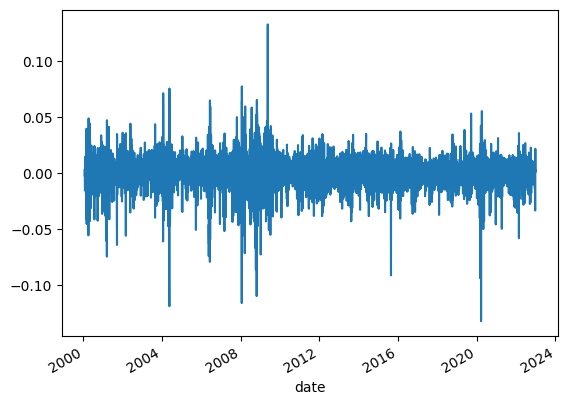

In [17]:
equal_weighted_index_returns['log_ret_close_to_close'].plot()

In [18]:
equal_weighted_index_returns = equal_weighted_index_returns.dropna()

In [66]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import probplot
import logging
from datetime import datetime

import time
from functools import wraps

def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"[{func.__name__}] executed in {end - start:.4f} seconds")
        return result
    return wrapper

def compute_log_returns(df):
    """ Compute log returns for a given price series. """
    return np.log(df / df.shift(1))

def compute_simple_returns(df):
    """ Compute simple returns for a given price series. """
    return df.pct_change()

def setup_logger(log_file='idiosyncratic_returns.log'):
    """Configure logging system"""
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger()

def generate_regression_plots(aligned_data, model, residuals, security, price_type):
    """Helper function to generate diagnostic plots."""
    plt.figure(figsize=(15, 12))
    plt.suptitle(f"{security} - {price_type} Regression Diagnostics", y=1.02)

    plt.subplot(2, 2, 1)
    sns.regplot(x='index_return', y='stock_return', data=aligned_data,
                scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ci=None)
    plt.xlabel(f"Index {price_type} Returns")
    plt.ylabel(f"Stock {price_type} Returns")
    plt.grid(True)

    plt.subplot(2, 2, 2)
    sns.histplot(residuals, bins=50, kde=True)
    plt.axvline(0, color="red", linestyle="--")
    plt.grid(True)

    plt.subplot(2, 2, 3)
    probplot(residuals, dist="norm", plot=plt)
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.scatter(model.predict(), residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

RETURN_TYPES = [ 'ret_close_to_close', 'ret_open_to_close', 'ret_close_to_open', 'ret_intraday_range' ]
LOG_RETURN_TYPES = [ 'log_ret_close_to_close', 'log_ret_open_to_close', 'log_ret_close_to_open', 'log_ret_intraday_range' ]

@timeit
def compute_idiosyncratic_returns(priceData, indexData, returnTypes=LOG_RETURN_TYPES,
                                universe=None, make_plots=False, merge_to_original=True,
                                log_stats=True, log_file='idiosyncratic_returns.log', regression_results=None):
    """
    Compute idiosyncratic returns with enhanced logging functionality.

    Parameters:
    priceData (pd.DataFrame): Original price data indexed by date with columns ['security', ...]
    indexData (pd.DataFrame): Index prices with matching price types, indexed by date
    price_types (list): Price columns to process
    universe (list): Securities to process (None=all available)
    make_plots (bool): Generate diagnostic plots
    merge_to_original (bool): Whether to merge results back to priceData
    log_stats (bool): Whether to log regression statistics
    log_file (str): Path to log file

    Returns:
    pd.DataFrame or dict: If merge_to_original=True returns enhanced DataFrame,
                         else returns dictionary of idiosyncratic returns
    """
    # Initialize logger
    logger = setup_logger(log_file)
    logger.info("Starting idiosyncratic returns computation")
    logger.info(f"Processing {len(returnTypes)} price types: {', '.join(returnTypes)}")

    # Set default universe if not provided
    if universe is None:
        universe = priceData['security'].unique()
        logger.info(f"Using default universe of {len(universe)} securities")
    else:
        logger.info(f"Processing custom universe of {len(universe)} securities")

    # Initialize storage
    idio_dict = {rt: {} for rt in returnTypes}
    results = priceData.copy() if merge_to_original else None
    stats_records = []

    # Verify index price types
    missing_types = [rt for rt in returnTypes if rt not in indexData.columns]
    if missing_types:
        error_msg = f"Index data missing price types: {missing_types}"
        logger.error(error_msg)
        raise ValueError(error_msg)
    else:
        logger.info("All required price types present in index data")

    # Precompute index returns
    index_returns = { rt: indexData[rt].dropna() for rt in returnTypes }
    # index_returns = {'PX_LAST': indexData['log_ret'].dropna()
    #                   }
    logger.info("Precomputed index returns for all price types")

    processed = 0
    for security in universe:
        try:
            sec_data = getStockPriceVolumeData(security)
            if sec_data is None or sec_data.empty:
                logger.warning(f"No data available for security: {security}")
                continue

            for return_type in returnTypes:
                if return_type not in sec_data.columns:
                    logger.debug(f"Price type {return_type} not found for {security}")
                    continue

                # Calculate returns and align data
                stock_returns = sec_data[return_type].dropna()
                # print(type(stock_returns), '----------------')
                # print(stock_returns.index)
                # print(stock_returns)

                # # Store log returns in results DataFrame
                # if merge_to_original:
                #   valid_indices = stock_returns.index.intersection(results.index)
                #   log_return_col = f"LOGRET_{return_type}"
                #   mask = (results['security'] == security) & (results.index.isin(valid_indices))
                #   results.loc[mask, log_return_col] = stock_returns.loc[valid_indices].values

                aligned_data = pd.concat([stock_returns, index_returns[return_type]],
                                       axis=1, join="inner").dropna()
                aligned_data.columns = ['stock_return', 'index_return']


                if len(aligned_data) < 30:
                    logger.warning(f"Insufficient data points ({len(aligned_data)}) for {security} {return_type}")
                    continue

                # print(aligned_data.dtypes)
                # print(aligned_data.head())
                # print(type(index_returns[return_type]), '----------------')
                # print(index_returns[return_type].index)
                # print(index_returns[return_type])

                # Run regression
                if regression_results:
                  regression_results_df = pd.read_csv(regression_results)
                  regression_results_filtered_df = regression_results_df[
                                                      (regression_results_df['security'] == security) &
                                                      (regression_results_df['return_type'] == return_type)
                                                  ]
                  alpha = regression_results_filtered_df.iloc[0]['alpha']
                  beta = regression_results_filtered_df.iloc[0]['beta']
                  predicted = alpha + beta * aligned_data['index_return']
                  residuals = aligned_data['stock_return'] - predicted
                  alpha_plus_epsilon = aligned_data['stock_return'] - beta * aligned_data['index_return']

                else:
                  X = sm.add_constant(aligned_data['index_return'])
                  y = aligned_data['stock_return']
                  model = sm.OLS(y, X).fit()
                  residuals = y - model.predict(X)
                  beta = model.params[1]                     # beta
                  alpha_plus_epsilon = y - beta * X['index_return']

                  print(f"{security}_{return_type} Regression Finished | R² = {model.rsquared:.4f}")

                # Store results
                idio_dict[return_type][security] = alpha_plus_epsilon #
                processed += 1

                # Log regression statistics
                if log_stats and regression_results is None:
                    stats_records.append({
                        'security': security,
                        'return_type': return_type,
                        'alpha': model.params[0],
                        'beta': model.params[1],
                        'r_squared': model.rsquared,
                        'observations': len(aligned_data)
                    })

                # Merge if requested
                if merge_to_original:
                    valid_indices = alpha_plus_epsilon.index.intersection(results.index)
                    col_name = f"IDIO_{return_type}"
                    mask = (results['security'] == security) & (results.index.isin(valid_indices))
                    results.loc[mask, col_name] = alpha_plus_epsilon.loc[valid_indices].values

                # Generate plots if requested
                if make_plots and regression_results is None:
                    generate_regression_plots(aligned_data, model, residuals, security, return_type)

        except Exception as e:
            logger.error(f"Error processing {security}: {str(e)}", exc_info=True)
            continue

    # Final logging summary
    logger.info(f"Completed processing. Successfully processed {processed} security/price-type combinations")
    if log_stats and regression_results is None:
      stats_df = pd.DataFrame(stats_records)
      stats_df.to_csv("stats_output_regression.csv", index=False)

    return results if merge_to_original else idio_dict

priceData = compute_idiosyncratic_returns(priceData, equal_weighted_index_returns, universe=CURR_UNIVERSE, merge_to_original=True, make_plots=False, regression_results='stats_output_regression.csv')

[compute_idiosyncratic_returns] executed in 851.6376 seconds


In [62]:
equal_weighted_index_returns

,ew_ret_close_to_close,ew_ret_open_to_close,ew_ret_close_to_open,ew_ret_intraday_range,log_ret_close_to_close,log_ret_open_to_close,log_ret_close_to_open,log_ret_intraday_range,n_constituents
date,,,,,,,,,
2000-01-25,-0.001314,0.000607,-0.001708,0.052904,-0.002029,-0.000006,-0.002023,0.051051,110
2000-01-27,-0.000149,-0.006162,0.006161,0.055445,-0.000984,-0.006834,0.005850,0.053611,114
2000-01-28,0.004561,0.001831,0.002758,0.055078,0.003710,0.001241,0.002469,0.053261,115
2000-01-31,-0.014301,-0.023095,0.009429,0.062231,-0.015517,-0.024109,0.008591,0.059808,118
2000-02-01,0.007887,0.006708,0.001506,0.054606,0.007096,0.006089,0.001008,0.052593,119
...,...,...,...,...,...,...,...,...,...
2022-12-26,0.022392,0.027695,-0.005087,0.045219,0.021822,0.026961,-0.005138,0.043862,200
2022-12-27,0.010061,0.003107,0.006956,0.025361,0.009896,0.002997,0.006900,0.024973,200
2022-12-28,0.000977,0.001075,-0.000071,0.023454,0.000886,0.000982,-0.000096,0.023094,200


<Axes: xlabel='date'>

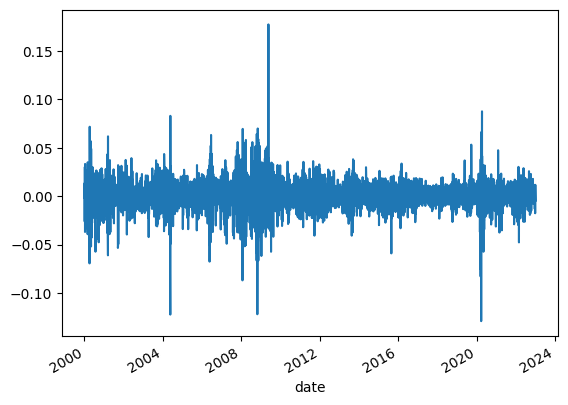

In [72]:
nifty50['PX_LAST'].pct_change().plot()

In [89]:
equal_weighted_index_returns[equal_weighted_index_returns['ew_ret_close_to_close'] <0.4]

,ew_ret_close_to_close,ew_ret_open_to_close,ew_ret_close_to_open,ew_ret_intraday_range,log_ret_close_to_close,log_ret_open_to_close,log_ret_close_to_open,log_ret_intraday_range,n_constituents
date,,,,,,,,,
1999-12-28,0.010969,0.014910,-0.003002,0.056933,0.009680,0.013152,-0.003472,0.054112,590
1999-12-29,-0.002987,-0.004654,0.001864,0.049635,-0.003840,-0.005213,0.001373,0.047999,622
1999-12-30,0.006633,0.002968,0.003843,0.057134,0.005828,0.002375,0.003453,0.054888,626
2000-01-03,0.075523,0.031226,0.044136,0.064491,0.072280,0.029831,0.042449,0.061247,625
2000-01-04,0.004905,-0.012325,0.017900,0.075610,0.003601,-0.013282,0.016883,0.072150,646
...,...,...,...,...,...,...,...,...,...
2022-12-26,0.022392,0.027695,-0.005087,0.045219,0.021822,0.026961,-0.005138,0.043862,1075
2022-12-27,0.010061,0.003107,0.006956,0.025361,0.009896,0.002997,0.006900,0.024973,1063
2022-12-28,0.000977,0.001075,-0.000071,0.023454,0.000886,0.000982,-0.000096,0.023094,1062


In [95]:
priceData.tail()

,security,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,EQY_WEIGHTED_AVG_PX,PX_VOLUME,totalVolume,maxStockVolume,volume_ratio,volume_max_ratio,returnsOpen,returnsClose,returnsHigh,returnsLow,LOGRET_PX_LAST,IDIO_PX_LAST
date,,,,,,,,,,,,,,,,,
2022-12-30,ORCP,365.00,374.00,360.00,364.05,364.2354,3380.0,3.340415e+09,316126759.0,0.000001,0.000011,0.020408,0.004969,0.019074,0.006430,NaN,NaN
2022-12-30,SUNF,117.40,118.60,111.35,112.25,115.4531,1138845.0,3.340415e+09,316126759.0,0.000341,0.003602,0.056230,-0.013620,0.018026,0.014579,NaN,NaN
2022-12-30,WH,1902.18,1930.60,1888.51,1899.64,1910.1009,26251.0,3.340415e+09,316126759.0,0.000008,0.000083,0.017035,-0.001335,-0.002954,0.024810,NaN,NaN
2022-12-30,OWF,112.20,112.95,110.05,111.10,111.8095,18736.0,3.340415e+09,316126759.0,0.000006,0.000059,0.004476,0.008625,0.000443,0.018981,NaN,NaN
2022-12-30,KS,354.97,363.70,347.34,348.94,356.1409,70202.0,3.340415e+09,316126759.0,0.000021,0.000222,0.007951,-0.010941,0.024046,0.002482,NaN,NaN


In [17]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import probplot
import logging
from datetime import datetime

def compute_log_returns(df):
    """ Compute log returns for a given price series. """
    return np.log(df / df.shift(1))

def compute_simple_returns(df):
    """ Compute simple returns for a given price series. """
    return df.pct_change()

def setup_logger(log_file='idiosyncratic_returns.log'):
    """Configure logging system"""
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger()

def compute_idiosyncratic_returns(priceData, indexData, price_types=['PX_LAST', 'PX_OPEN', 'PX_HIGH', 'PX_LOW'],
                                universe=None, make_plots=False, merge_to_original=True,
                                log_stats=True, log_file='idiosyncratic_returns.log'):
    """
    Compute idiosyncratic returns with enhanced logging functionality.

    Parameters:
    priceData (pd.DataFrame): Original price data indexed by date with columns ['security', ...]
    indexData (pd.DataFrame): Index prices with matching price types, indexed by date
    price_types (list): Price columns to process
    universe (list): Securities to process (None=all available)
    make_plots (bool): Generate diagnostic plots
    merge_to_original (bool): Whether to merge results back to priceData
    log_stats (bool): Whether to log regression statistics
    log_file (str): Path to log file

    Returns:
    pd.DataFrame or dict: If merge_to_original=True returns enhanced DataFrame,
                         else returns dictionary of idiosyncratic returns
    """
    # Initialize logger
    logger = setup_logger(log_file)
    logger.info("Starting idiosyncratic returns computation")
    logger.info(f"Processing {len(price_types)} price types: {', '.join(price_types)}")

    # Set default universe if not provided
    if universe is None:
        universe = priceData['security'].unique()
        logger.info(f"Using default universe of {len(universe)} securities")
    else:
        logger.info(f"Processing custom universe of {len(universe)} securities")

    # Initialize storage
    idio_dict = {pt: {} for pt in price_types}
    results = priceData.copy() if merge_to_original else None
    stats_records = []

    # Verify index price types
    missing_types = [pt for pt in price_types if pt not in indexData.columns]
    if missing_types:
        error_msg = f"Index data missing price types: {missing_types}"
        logger.error(error_msg)
        raise ValueError(error_msg)
    else:
        logger.info("All required price types present in index data")

    # Precompute index returns
    index_returns = {pt: compute_log_returns(indexData[pt]).dropna()
                    for pt in price_types}
    logger.info("Precomputed index returns for all price types")

    processed = 0
    for security in universe:
        try:
            sec_data = getStockPriceVolumeData(security)
            if sec_data is None or sec_data.empty:
                logger.warning(f"No data available for security: {security}")
                continue

            for price_type in price_types:
                if price_type not in sec_data.columns:
                    logger.debug(f"Price type {price_type} not found for {security}")
                    continue

                # Calculate returns and align data
                stock_returns = compute_log_returns(sec_data[price_type]).dropna()

                # Store log returns in results DataFrame
                if merge_to_original:
                  valid_indices = stock_returns.index.intersection(results.index)
                  log_return_col = f"LOGRET_{price_type}"
                  mask = (results['security'] == security + IN_EQUITY_PREFIX) & (results.index.isin(valid_indices))
                  results.loc[mask, log_return_col] = stock_returns.loc[valid_indices].values

                aligned_data = pd.concat([stock_returns, index_returns[price_type]],
                                       axis=1, join="inner").dropna()
                aligned_data.columns = ['stock_return', 'index_return']

                if len(aligned_data) < 30:
                    logger.warning(f"Insufficient data points ({len(aligned_data)}) for {security} {price_type}")
                    continue

                # Run regression
                X = sm.add_constant(aligned_data['index_return'])
                y = aligned_data['stock_return']
                model = sm.OLS(y, X).fit()
                residuals = y - model.predict(X)
                print(f"{security}_{price_type} Regression Finished | R² = {model.rsquared:.4f}")

                # Store results
                idio_dict[price_type][security] = residuals
                processed += 1

                # Log regression statistics
                if log_stats:
                    stats_records.append({
                        'security': security,
                        'price_type': price_type,
                        'alpha': model.params[0],
                        'beta': model.params[1],
                        'r_squared': model.rsquared,
                        'observations': len(aligned_data)
                    })

                # Merge if requested
                if merge_to_original:
                    valid_indices = residuals.index.intersection(results.index)
                    col_name = f"IDIO_{price_type}"
                    mask = (results['security'] == security + IN_EQUITY_PREFIX) & (results.index.isin(valid_indices))
                    results.loc[mask, col_name] = residuals.loc[valid_indices].values

                # Generate plots if requested
                if make_plots:
                    generate_regression_plots(aligned_data, model, residuals, security, price_type)

        except Exception as e:
            logger.error(f"Error processing {security}: {str(e)}", exc_info=True)
            continue

    # Final logging summary
    logger.info(f"Completed processing. Successfully processed {processed} security/price-type combinations")

    return results if merge_to_original else idio_dict

def generate_regression_plots(aligned_data, model, residuals, security, price_type):
    """Helper function to generate diagnostic plots."""
    plt.figure(figsize=(15, 12))
    plt.suptitle(f"{security} - {price_type} Regression Diagnostics", y=1.02)

    plt.subplot(2, 2, 1)
    sns.regplot(x='index_return', y='stock_return', data=aligned_data,
                scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ci=None)
    plt.xlabel(f"Index {price_type} Returns")
    plt.ylabel(f"Stock {price_type} Returns")
    plt.grid(True)

    plt.subplot(2, 2, 2)
    sns.histplot(residuals, bins=50, kde=True)
    plt.axvline(0, color="red", linestyle="--")
    plt.grid(True)

    plt.subplot(2, 2, 3)
    probplot(residuals, dist="norm", plot=plt)
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.scatter(model.predict(), residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


#priceData = compute_idiosyncratic_returns(priceData, nifty200, universe=CURR_UNIVERSE[:30], merge_to_original=True, make_plots=True)

In [ ]:
df[df['security'] == 'ADANIGR IN Equity']

NameError: name 'df' is not defined

In [ ]:
nifty200.loc['2018-06-20']

,2018-06-20
Unnamed: 0,3605
security,NSE200TR Index
PX_OPEN,7113.24
PX_HIGH,7113.24
PX_LOW,7113.24
PX_LAST,7086.53
EQY_WEIGHTED_AVG_PX,NaN


In [ ]:
priceData.columns

Index(['security', 'PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST',
       'EQY_WEIGHTED_AVG_PX', 'PX_VOLUME', 'totalVolume', 'maxStockVolume',
       'volume_ratio', 'volume_max_ratio', 'returnsOpen', 'returnsClose',
       'returnsHigh', 'returnsLow'],
      dtype='object')

In [ ]:
CURR_UNIVERSE

#Model 1

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,4.5) # Make the default figures a bit bigger
import numpy as np
import random
import pandas as pd
from datetime import datetime
from datetime import date
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [67]:
'''
utoencoder Model: An autoencoder is implemented as a class AnomalyDetector that extends the tf.keras.models.Model class.
The autoencoder is composed of two parts: an encoder and a decoder.
The encoder reduces the dimensionality of the input data, and the decoder restores it to its original shape.
'''

# class AnomalyDetectorNN(Model):
#     def __init__(self, input_dim=30):
#         super(AnomalyDetectorNN, self).__init__()

#         # Encoder: Compress input into a smaller representation
#         self.encoder = tf.keras.Sequential([
#             layers.Dense(128, activation="relu", input_shape=(input_dim,)),  # Input shape added
#             layers.Dense(16, activation="relu")
#         ])

#         # Decoder: Reconstruct input from encoded representation
#         self.decoder = tf.keras.Sequential([
#             layers.Dense(128, activation="relu"),
#             layers.Dense(input_dim, activation="sigmoid")  # Ensures output matches input dimension
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)   # Encode input
#         decoded = self.decoder(encoded)  # Decode back to original shape
#         return decoded

# autoencoder = AnomalyDetectorNN(30)

class AnomalyDetectorNN(Model):
    def __init__(self, window_size=30, num_features=5):
        super(AnomalyDetectorNN, self).__init__()

        input_dim = window_size * num_features  # Flattened input size

        self.encoder = tf.keras.Sequential([
            layers.Flatten(),  # Convert (batch, 30, features) → (batch, 30*num_features)
            layers.Dense(128, activation="relu"),
            layers.Dense(16, activation="relu")
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation="relu"),
            layers.Dense(input_dim, activation="sigmoid"),  # Linear activation
            layers.Reshape((window_size, num_features))  # Reshape back to original
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [68]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# class LSTMAutoencoder(Model):
#     def __init__(self, input_dim=30, latent_dim=16):
#         super(LSTMAutoencoder, self).__init__()

#         # Encoder: Compress input into a smaller representation
#         self.encoder = tf.keras.Sequential([
#             layers.LSTM(128, activation="relu", return_sequences=True, input_shape=(input_dim, 1)),
#             layers.LSTM(latent_dim, activation="relu", return_sequences=False)  # Bottleneck
#         ])

#         # Decoder: LSTM reconstructing original input
#         self.decoder = tf.keras.Sequential([
#             layers.RepeatVector(input_dim),  # Expands bottleneck vector across time steps
#             layers.LSTM(128, activation="relu", return_sequences=True),
#             layers.TimeDistributed(layers.Dense(1))  # Output shape matches input (30,1)
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)  # Compress input into bottleneck representation
#         decoded = self.decoder(encoded)  # Reconstruct sequence from bottleneck
#         return decoded

# # Example usage
# input_dim = 30  # Sequence length (time steps)
# latent_dim = 8  # Compressed representation

# autoencoder = LSTMAutoencoder(input_dim=input_dim, latent_dim=latent_dim)
# #autoencoder.compile(optimizer='adam', loss='mae')

import tensorflow as tf
from tensorflow.keras import Model, layers

# class LSTMAutoencoder(Model):
#     def __init__(self, timeSteps=30, numFeatures=5, latent_dim=8):
#         super(LSTMAutoencoder, self).__init__()

#         # Encoder: Compress input into a latent representation
#         self.encoder = tf.keras.Sequential([
#             layers.LSTM(128, activation="relu", return_sequences=True, input_shape=(timeSteps, numFeatures)),
#             layers.LSTM(latent_dim, activation="relu", return_sequences=False)  # Bottleneck
#         ])

#         # Decoder: Reconstruct original input shape (timeSteps, numFeatures)
#         self.decoder = tf.keras.Sequential([
#             layers.RepeatVector(timeSteps),  # Expand bottleneck across time steps
#             layers.LSTM(128, activation="relu", return_sequences=True),
#             layers.TimeDistributed(layers.Dense(numFeatures))  # Ensure output matches input shape
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)  # Compress input into latent space
#         decoded = self.decoder(encoded)  # Reconstruct input from latent space
#         return decoded

class LSTMAutoencoder(Model):
    def __init__(self, timeSteps=30, numFeatures=5, latent_dim=16):
        super(LSTMAutoencoder, self).__init__()

        # Encoder: Compress input into a latent representation
        self.encoder = tf.keras.Sequential([
            layers.LSTM(128, activation="relu", return_sequences=True, input_shape=(timeSteps, numFeatures)),
            layers.LSTM(latent_dim, activation="relu", return_sequences=False)  # Keep sequences
        ])

        # Decoder: Reconstruct the original input shape (timeSteps, numFeatures)
        self.decoder = tf.keras.Sequential([
            layers.RepeatVector(timeSteps),  # Expand latent representation
            layers.LSTM(128, activation="relu", return_sequences=True),
            layers.LSTM(64, activation="relu", return_sequences=True),  # Extra LSTM layer
            layers.TimeDistributed(layers.Dense(numFeatures))  # Ensure output matches input
        ])

    def call(self, x):
        encoded = self.encoder(x)  # Compress input
        decoded = self.decoder(encoded)  # Reconstruct input
        return decoded



In [69]:
from sklearn.preprocessing import MinMaxScaler
def normalize_window_roll(data, window_size, step=1, cols_to_keep=None):
    """
    Normalizes a rolling window of data using MinMaxScaler.

    Parameters:
    - data: pd.DataFrame, with datetime index and multiple columns.
    - window_size: int, size of rolling window.
    - step: int, step size for moving window.
    - cols_to_keep: list, column names to keep for normalization.

    Returns:
    - X: np.array of shape (num_samples, window_size, num_features).
    - index_map: list of lists, mapping each index to dates.
    """

    X = []
    index_map = []

    # If cols_to_keep is provided, filter only those columns
    if cols_to_keep:
        data = data[cols_to_keep]

    for i in range(0, len(data) - window_size, step):
        x_window = data.iloc[i : i + window_size]  # Extract rolling window
        index_map.append(x_window.index.to_list())  # Store index list

        # Normalize across all selected columns
        scaler = MinMaxScaler(feature_range=(0, 1))
        x_window_scaled = scaler.fit_transform(x_window)  # Shape: (window_size, num_features)

        X.append(x_window_scaled)

    X = np.array(X)  # Shape: (num_samples, window_size, num_features)

    return X, index_map



In [70]:
import numpy as np
import pandas as pd

def split_data(X, index_map, test_start, test_end, val_start, val_end):
    """
    Splits data into train, validation, and test sets based on given date ranges.

    Parameters:
    - X: np.array (N_data x seq_length x num_features), the normalized rolling window data.
    - index_map: list of lists containing pd.Timestamp (N_data x seq_length), mapping each index in X to a sequence of dates.
    - test_start: datetime.date or pd.Timestamp, start date for test set.
    - test_end: datetime.date or pd.Timestamp, end date for test set.
    - val_start: datetime.date or pd.Timestamp, start date for validation set.
    - val_end: datetime.date or pd.Timestamp, end date for validation set.

    Returns:
    - X_train, X_val, X_test: np.array, split data (same 3D shape structure).
    - index_train, index_val, index_test: list of lists of pd.Timestamp.
    """

    # Convert all date inputs to pd.Timestamp for consistency
    test_start, test_end = pd.Timestamp(test_start), pd.Timestamp(test_end)
    val_start, val_end = pd.Timestamp(val_start), pd.Timestamp(val_end)

    # Ensure index_map is not empty
    if not index_map:
        seq_length = X.shape[1] if X.ndim == 3 else 0
        num_features = X.shape[2] if X.ndim == 3 else 0
        return (np.empty((0, seq_length, num_features)),  # X_train
                np.empty((0, seq_length, num_features)),  # X_val
                np.empty((0, seq_length, num_features)),  # X_test
                [], [], [])  # Empty index lists

    # Extract representative date (first date of each sequence in index_map)
    index_representative = np.array([dates[0] for dates in index_map])

    # Identify test indices
    test_mask = (index_representative >= test_start) & (index_representative <= test_end)
    test_indices = np.where(test_mask)[0]
    X_test = X[test_indices] if len(test_indices) > 0 else np.empty((0, X.shape[1], X.shape[2]))
    index_test = [index_map[i] for i in test_indices] if len(test_indices) > 0 else []

    # Identify validation indices
    val_mask = (index_representative >= val_start) & (index_representative <= val_end)
    val_indices = np.where(val_mask)[0]
    X_val = X[val_indices] if len(val_indices) > 0 else np.empty((0, X.shape[1], X.shape[2]))
    index_val = [index_map[i] for i in val_indices] if len(val_indices) > 0 else []

    # Remaining data for training
    train_mask = ~(test_mask | val_mask)
    train_indices = np.where(train_mask)[0]
    X_train = X[train_indices] if len(train_indices) > 0 else np.empty((0, X.shape[1], X.shape[2]))
    index_train = [index_map[i] for i in train_indices] if len(train_indices) > 0 else []

    return X_train, X_val, X_test, index_train, index_val, index_test


In [71]:
#Source: https://www.tensorflow.org/tutorials/generative/autoencoder
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, data), axis=1)
  return tf.math.less(loss, threshold)

In [72]:
priceData = priceData.dropna()

In [73]:
def get_split_dates(prices_df, split=(0.6, 0.2, 0.2)):
    """
    Get train, calibration, and test date boundaries based on given split percentages.

    Parameters:
    - prices_df (pd.DataFrame): DataFrame with datetime index.
    - split (tuple): Percent split (train, cal, test). Should sum to 1.0.

    Returns:
    - dict with 'train', 'cal', 'test' keys and their corresponding date ranges.
    """
    assert np.isclose(sum(split), 1.0), "Split ratios must sum to 1.0"

    dates = prices_df.index
    dates = dates.date if isinstance(dates, pd.DatetimeIndex) else [d.date() for d in dates]
    n = len(dates)

    n_train = int(n * split[0])
    n_val = int(n * split[1])

    train_dates = dates[:n_train]
    val_dates = dates[n_train:n_train + n_val]
    test_dates = dates[n_train + n_val:]

    return {
        "train": (train_dates[0], train_dates[-1]),
        "val": (val_dates[0], val_dates[-1]),
        "test": (test_dates[0], test_dates[-1])
    }


In [74]:
import pandas as pd

def calculate_returns(df, anomaly_dates, months=[3, 6]):
    """
    Compute 3-month and 6-month returns from anomaly dates, selecting the next available date if missing.

    Parameters:
    df (pd.DataFrame): DataFrame with 'PX_LAST' prices and datetime index.
    anomaly_dates (list): List of anomaly dates (as strings or datetime).
    months (list): List of months for return calculation (default: [3, 6]).

    Returns:
    pd.DataFrame: Table with anomaly dates, 3M & 6M returns.
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)  # Ensure index is datetime
    sorted_dates = df.index.sort_values()  # Ensure index is sorted
    results = []

    for date in anomaly_dates:
        anomaly_date = pd.to_datetime(date)
        if anomaly_date not in df.index:
            continue  # Skip if anomaly date is missing

        price_at_anomaly = df.loc[anomaly_date, "PX_LAST"]
        row = {"Anomaly Date": anomaly_date, "Price at Anomaly": price_at_anomaly}

        for m in months:
            future_date = anomaly_date + pd.DateOffset(months=m)

            # Find the next available date if the exact future date is missing
            future_idx = sorted_dates.searchsorted(future_date)
            if future_idx < len(sorted_dates):  # Ensure index is within bounds
                adjusted_future_date = sorted_dates[future_idx]
                future_price = df.loc[adjusted_future_date, "PX_LAST"]
                return_m = (future_price - price_at_anomaly) * 100 / price_at_anomaly
                row[f"{m}M Return"] = return_m
            else:
                row[f"{m}M Return"] = None  # No future data available

        results.append(row)

    return pd.DataFrame(results)


def calculate_vol_factor_normalized_returns(
    price_df,
    anomaly_dates,
    index_df=None,
    return_type="log",  # or "simple"
    return_col="PX_LAST",
    months=[3, 6],
    vol_window=63
):
    """
    Compute forward returns from anomaly dates, normalized by stock vol / index vol.

    Parameters:
    - price_df (pd.DataFrame): Must have DateTime index and columns like 'log_return' or 'ret'.
    - anomaly_dates (list): List of anomaly dates (strings or datetimes).
    - index_df (pd.DataFrame): Index returns dataframe with same return_type column.
    - return_type (str): "log" or "simple".
    - return_col (str): Price column used to compute raw forward return.
    - months (list): List of months to compute forward returns.
    - vol_window (int): Rolling window in trading days to compute vol.

    Returns:
    - pd.DataFrame
    """
    df = price_df.copy()

    if return_type == "log":
        ret_col = "log_ret_close_to_close"
    else:
        ret_col = "ret_close_to_close"

    if return_type == "log":
        ret_col_idx = "log_ret_close_to_close"
    else:
        ret_col_idx = "ew_ret_close_to_close"

    # Compute rolling vol for stock
    if ret_col not in df.columns:
        raise ValueError(f"{ret_col} column not found in price_df")

    df["vol_stock"] = df[ret_col].rolling(vol_window).std()

    # Compute rolling vol for index if provided
    vol_index = None
    if index_df is not None:
        index_df = index_df.copy()

        if ret_col not in index_df.columns:
            raise ValueError(f"{ret_col} column not found in index_df")

        index_df["vol_index"] = index_df[ret_col_idx].rolling(vol_window).std()
        vol_index = index_df["vol_index"]

    results = []
    sorted_dates = df.index

    for date in anomaly_dates:
        anomaly_date = pd.to_datetime(date)
        if anomaly_date not in df.index:
            continue

        price_at_anomaly = df.loc[anomaly_date, return_col]
        vol_stock = df.loc[anomaly_date, "vol_stock"] if not pd.isna(df.loc[anomaly_date, "vol_stock"]) else None
        vol_idx = vol_index.loc[anomaly_date] if vol_index is not None and anomaly_date in vol_index.index else None
        vol_ratio = vol_stock / vol_idx if vol_stock and vol_idx else None

        row = {
            "Anomaly Date": anomaly_date,
            "Price at Anomaly": price_at_anomaly,
            "Stock Vol": vol_stock,
            "Index Vol": vol_idx,
            "Vol Ratio": vol_ratio
        }

        for m in months:
            future_date = anomaly_date + pd.DateOffset(months=m)
            future_idx = sorted_dates.searchsorted(future_date)

            if future_idx < len(sorted_dates):
                adj_future_date = sorted_dates[future_idx]
                future_price = df.loc[adj_future_date, return_col]

                return_m = 100 * (future_price - price_at_anomaly) / price_at_anomaly

                row[f"{m}M Return"] = return_m
                row[f"{m}M Normalized"] = return_m / vol_ratio if vol_ratio else None
            else:
                row[f"{m}M Return"] = None
                row[f"{m}M Normalized"] = None

        results.append(row)

    return pd.DataFrame(results)


def evaluate_predictions(returns_df):
    """
    Compute statistics to evaluate anomaly-based predictions.

    Parameters:
    returns_df (pd.DataFrame): DataFrame containing 'Ticker', 'Anomaly Date', '3M Return', '6M Return'.

    Returns:
    pd.DataFrame: Summary table with counts of strong movements.
    """
    stats = []

    for ticker, group in returns_df.groupby("Ticker"):
        total_anomalies = len(group)

        # Count occurrences where absolute return exceeds threshold
        count_abs_3m_10 = (group["3M Return"].abs() > 10).sum()
        count_abs_6m_10 = (group["6M Return"].abs() > 10).sum()
        count_abs_3m_20 = (group["3M Return"].abs() > 20).sum()
        count_abs_6m_20 = (group["6M Return"].abs() > 20).sum()

        stats.append({
            "Ticker": ticker,
            "Total Anomalies": total_anomalies,
            "|3M Return| > 10%": count_abs_3m_10,
            "|6M Return| > 10%": count_abs_6m_10,
            "|3M Return| > 20%": count_abs_3m_20,
            "|6M Return| > 20%": count_abs_6m_20
        })

    return pd.DataFrame(stats)


Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 180ms/step - loss: 0.2786 - val_loss: 0.1909
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 0.1944 - val_loss: 0.1784
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.1773 - val_loss: 0.1687
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - loss: 0.1700 - val_loss: 0.1678
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - loss: 0.1669 - val_loss: 0.1648
Epoch 6/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - loss: 0.1661 - val_loss: 0.1666
Epoch 7/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 0.1669 - val_loss: 0.1639
Epoch 8/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - loss: 0.1657 - val_loss: 0.1652
Epoch 9/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.1642 - val_loss: 0.1634
Epoch 10/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - loss: 0.1641 - val_loss: 0.1620
Epoch 11/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 0.1619 - val_loss: 0.1628
Epoch 12/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - loss: 0.

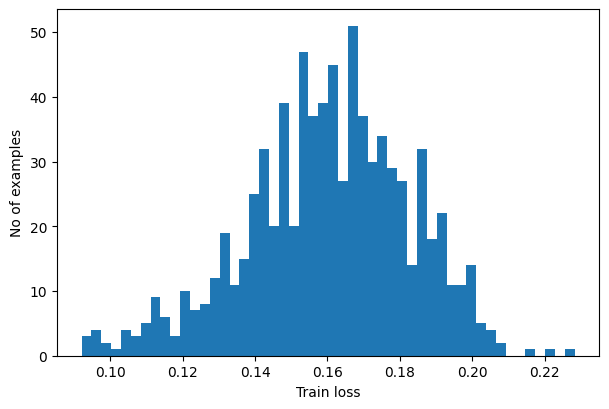

Threshold:  0.18296025210859168
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


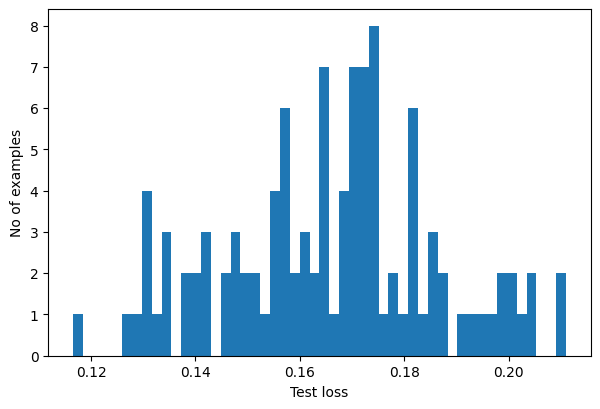

[Timestamp('2020-09-16 00:00:00'), Timestamp('2022-12-30 00:00:00')]


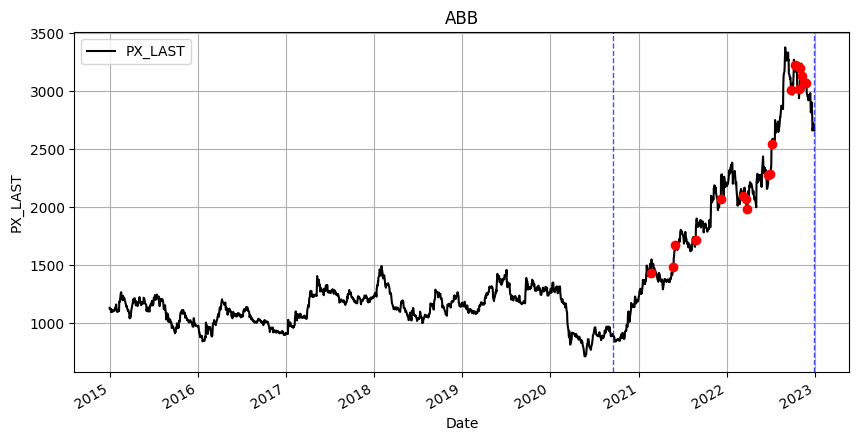

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 364ms/step - loss: 0.3418 - val_loss: 0.2223
Epoch 2/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.2192 - val_loss: 0.2110
Epoch 3/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.2064 - val_loss: 0.2023
Epoch 4/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.1977 - val_loss: 0.1978
Epoch 5/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.1986 - val_loss: 0.1956
Epoch 6/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.1912 - val_loss: 0.1903
Epoch 7/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.1900 - val_loss: 0.1889
Epoch 8/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.1859 - val_loss: 0.1860
Epoch 9/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - loss: 0.1846 - val_loss: 0.1851
Epoch 10/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.1864 - val_loss: 0.1845
Epoch 11/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.1827 - val_loss: 0.1845
Epoch 12/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/ste

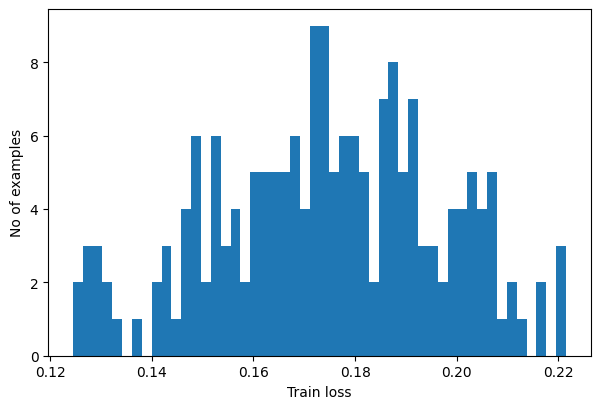

Threshold:  0.19681255017263957
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


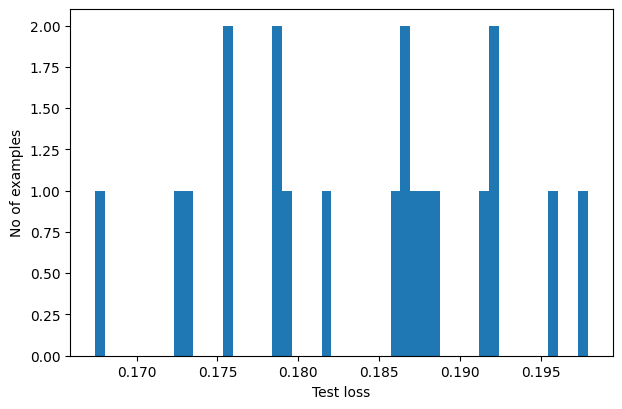

[Timestamp('2022-06-23 00:00:00'), Timestamp('2022-12-30 00:00:00')]


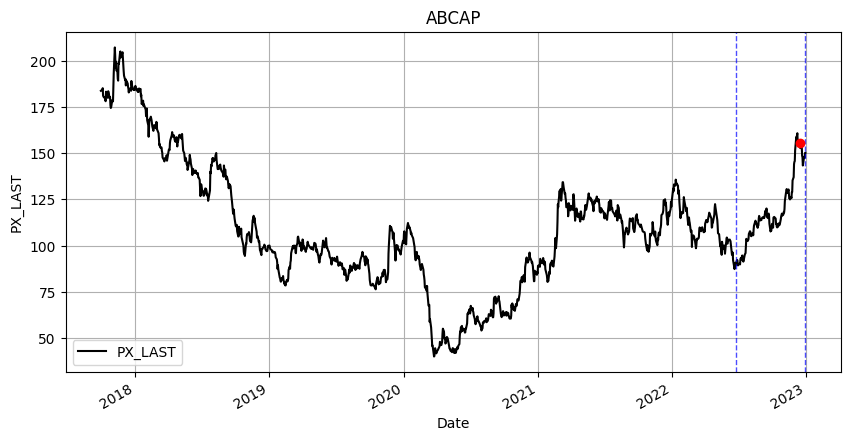

<ipython-input-81-f237c1bd3c5d>:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  returnsAtAnomaliesDf = pd.concat(


In [81]:
import json
#TICKERS = CURR_UNIVERSE
TICKERS = CURR_UNIVERSE
PRICE_TYPE = 'PX_LAST'
#COLS_TO_KEEP = ['PX_LAST','PX_OPEN', 'PX_HIGH', 'PX_LOW', 'volume_max_ratio' ]
#COLS_TO_KEEP = ['PX_LAST','PX_OPEN', 'PX_HIGH', 'PX_LOW', 'volume_ratio' ]
#COLS_TO_KEEP = ['returnsClose','returnsOpen', 'returnsHigh', 'returnsLow', 'volume_max_ratio' ]
# COLS_TO_KEEP = [ 'volume_max_ratio', 'Price_Spread', 'Body_Size', 'Upper_Shadow', 'Lower_Shadow', 'Close_Open_Gap',
#                 'SMA_5', 'SMA_20', 'MACD', 'MACD_Signal', 'RSI', 'ATR', 'Bollinger_Upper', 'Bollinger_Lower', 'MFI', 'PX_LAST','PX_OPEN', 'PX_HIGH', 'PX_LOW' ]
COLS_TO_KEEP = ['IDIO_log_ret_close_to_close', 'IDIO_log_ret_open_to_close',
       'IDIO_log_ret_close_to_open', 'IDIO_log_ret_intraday_range', 'volume_max_ratio']
#COLS_TO_KEEP= ['volume_max_ratio', 'Price_Spread', 'Body_Size', 'Upper_Shadow', 'Lower_Shadow', 'Close_Open_Gap']
# input_dim = 30
# latent_dim = 8
MODEL_INFO = "idio_returns"
returnsAtAnomalies = {}

for ticker in TICKERS:
  try:
    prices = getStockPriceVolumeData(ticker)

    X, index_map = normalize_window_roll(prices,30,5,COLS_TO_KEEP)
    split_dates = get_split_dates(prices, split=(0.6, 0.2, 0.2))
    # startTest = date(2019, 1, 1)
    # endTest = date(2021, 1, 1)

    # startVal = date(2014, 1, 1)
    # endVal = date(2018, 1, 1)
    startTest = split_dates['test'][0]
    endTest = split_dates['test'][1]

    startVal = split_dates['val'][0]
    endVal = split_dates['val'][1]

    X_train, X_val, X_test, index_train, index_val, index_test = split_data(X, index_map, startTest, endTest, startVal, endVal)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

    ########################### CHANGE MDOEL HERE ###########################

    #autoencoder = AnomalyDetectorNN(30, 1)
    autoencoder = LSTMAutoencoder(30, len(COLS_TO_KEEP), 16)
    autoencoder.compile(optimizer='adam', loss='mae')


    history = autoencoder.fit(X_train,X_train, epochs=80,
                        validation_data=(X_val, X_val),
                        batch_size=16,
                        callbacks=[early_stopping])

    model_path = folder_path + '/' + 'results' + autoencoder.__class__.__name__ + '_' + MODEL_INFO + '_' + ticker +'.keras'
    history_path = model_path + '_history.json'
    autoencoder.save(model_path)
    with open(history_path, 'w') as f:
        json.dump(history.history, f)
    reconstructions = autoencoder.predict(X_train)
    train_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, X_train), axis=1)

    plt.hist(train_loss[None,:], bins=50)
    plt.xlabel("Train loss")
    plt.ylabel("No of examples")
    plt.show()

    threshold = np.mean(train_loss) + np.std(train_loss)
    #threshold = np.max(train_loss)
    print("Threshold: ", threshold)

    reconstructions = autoencoder.predict(X_test)
    test_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, X_test), axis=1)

    plt.hist(test_loss[None, :], bins=50)
    plt.xlabel("Test loss")
    plt.ylabel("No of examples")
    plt.show()

    preds = predict(autoencoder, X_test, threshold)

    anomalousIndexIds  = np.where(preds == False)[0]

    dotDates = [index_test[i][-1] for i in anomalousIndexIds]
    plotPrice(ticker, PRICE_TYPE, date(2015, 1, 1), None, dotDates, lineDates=[startTest, endTest], saveSuffix=autoencoder.__class__.__name__ + MODEL_INFO)

    returns = calculate_vol_factor_normalized_returns(prices, dotDates, equal_weighted_index_returns)
    returnsAtAnomalies[ticker] = returns

    returnsAtAnomaliesDf = pd.concat(
      [df.assign(Ticker=ticker) for ticker, df in returnsAtAnomalies.items()],
      ignore_index=True
  )
    returnsAtAnomaliesDf.to_csv(folder_path + '/' + 'results' + autoencoder.__class__.__name__ +"_" + MODEL_INFO + '.csv'),

  except Exception as e:
    print(f"Error processing {ticker}: {e}")


# results = evaluate_predictions(returnsAtAnomaliesDf)
# results.to_csv('results' + autoencoder.__class__.__name__ + MODEL_INFO + '.csv')


In [ ]:
evaluate_predictions(returnsAtAnomaliesDf)

In [60]:
returnsAtAnomaliesDf

,Anomaly Date,Price at Anomaly,Stock Vol,Index Vol,Vol Ratio,3M Return,3M Normalized,6M Return,6M Normalized,Ticker
0,2020-11-03,865.24,0.016905,0.011404,1.482376,64.969257,43.827785,59.230965,39.956775,ABB
1,2021-04-30,1367.09,0.019760,0.013131,1.504785,23.015310,15.294748,50.565800,33.603335,ABB
2,2021-05-17,1406.18,0.017482,0.012184,1.434782,22.854115,15.928631,54.264034,37.820399,ABB
3,2021-07-27,1652.03,0.015974,0.006106,2.616240,12.614178,4.821491,33.268766,12.716251,ABB
4,2021-08-03,1653.57,0.016142,0.006107,2.643318,23.836910,9.017798,38.014115,14.381211,ABB
5,2021-10-14,1800.35,0.016832,0.007551,2.229150,28.727192,12.887059,20.038326,8.989221,ABB
6,2021-10-22,1889.72,0.016961,0.008033,2.111535,26.140381,12.379801,13.188197,6.245787,ABB
7,2021-12-21,2178.43,0.024353,0.011265,2.161760,-4.977438,-2.302493,1.472620,0.681213,ABB
8,2022-02-09,2218.02,0.023834,0.012009,1.984640,3.143795,1.584063,23.932156,12.058689,ABB
9,2022-03-10,2135.82,0.020022,0.015404,1.299741,8.398180,6.461423,54.680170,42.070038,ABB


#Direction of trade

In [ ]:
import pandas as pd
import numpy as np

def signalFromAnomaly(data, anomalyDates):
    """
    Generate trading signals based on anomalies using trend & mean reversion filters.

    Parameters:
    data (pd.DataFrame): DataFrame with 'Close' prices and date index.
    anomalyDates (list): List of dates (as strings) where anomalies were detected.

    Returns:
    pd.DataFrame: Original DataFrame with a new 'Signal' column.
    """
    df = data.copy()

    # Ensure the index is a datetime index
    df.index = pd.to_datetime(df.index)

    # Compute Moving Averages
    df['SMA_5'] = df['PX_LAST'].rolling(window=5).mean()
    df['SMA_20'] = df['PX_LAST'].rolling(window=20).mean()

    # Compute Bollinger Bands
    rolling_mean = df['PX_LAST'].rolling(window=20).mean()
    rolling_std = df['PX_LAST'].rolling(window=20).std()
    df['BB_Upper'] = rolling_mean + (2 * rolling_std)
    df['BB_Lower'] = rolling_mean - (2 * rolling_std)

    # Compute RSI manually
    delta = df['PX_LAST'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain).rolling(window=14, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=14, min_periods=1).mean()

    rs = avg_gain / (avg_loss + 1e-10)  # Avoid division by zero
    df['RSI'] = 100 - (100 / (1 + rs))

    # Compute Momentum (5-day return)
    df['Momentum'] = df['PX_LAST'].pct_change(periods=5)

    # Initialize Signal Column
    df['Signal'] = 0

    # Generate Signals
    for date in anomalyDates:
        date = pd.to_datetime(date)
        if date in df.index:
            sma5 = df.loc[date, 'SMA_5']
            sma20 = df.loc[date, 'SMA_20']
            rsi = df.loc[date, 'RSI']
            close = df.loc[date, 'PX_LAST']
            upper_bb = df.loc[date, 'BB_Upper']
            lower_bb = df.loc[date, 'BB_Lower']
            momentum = df.loc[date, 'Momentum']

            # Trend-Following: Buy if SMA5 > SMA20 (Uptrend), Sell if SMA5 < SMA20 (Downtrend)
            if sma5 > sma20:
                signal = 1  # Buy
            elif sma5 < sma20:
                signal = -1  # Sell
            else:
                signal = 0  # No clear trend

            # Mean Reversion Filters
            if close >= upper_bb or rsi > 70:
                signal = -1  # Overbought, Sell
            elif close <= lower_bb or rsi < 30:
                signal = 1  # Oversold, Buy

            # Momentum Confirmation (Only take trade if past returns support it)
            if momentum > 0 and signal == 1:
                signal = 0  # Avoid buying into strong price rise
            elif momentum < 0 and signal == -1:
                signal = 0  # Avoid selling into strong decline

            df.loc[date, 'Signal'] = signal

    return df

#Quality of Trade

#Volume normalization (DON)

#Remove index component (NEED INDEX TIME SERIES)

#Use all features (DONE)

# Need to have recent test period and have a look at stocks where we do n't have anough data like Adani etc...

# Rough

In [ ]:
TICKER = 'SBIN'
PRICE_TYPE = 'PX_LAST'
prices = getStockPriceVolumeData(TICKER, start=date(2010, 1, 1))[PRICE_TYPE]
prices.rename('price', inplace=True)
prices.dropna(inplace=True) # only 2 nan dates for reliance for eg.

In [ ]:
# should we smoothen the data ?
X, index_map = normalize_window_roll(prices,30)

In [35]:
print(X.shape)
print(prices.shape)
print(len(index_map))

(1132, 30, 5)
(5690, 49)
1132


In [ ]:
train_size = int(0.7*X.shape[0])
test_size = int(0.1*X.shape[0])
val_size = int(0.2*X.shape[0])

X_train = X[:train_size]
X_val = X[train_size+test_size:train_size+val_size+test_size]
X_test = X[train_size:train_size+test_size]

val_index_offset = train_size + test_size
test_index_offset = train_size
#X_val = X[train_size+test_size:train_size+test_size+val_size]

In [ ]:
'''
Training the model: The autoencoder is trained using the stock market data using the fit function.
An EarlyStopping callback is added to stop the training if the validation loss does not improve for 2 consecutive epochs.
'''
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(X_train,X_train, epochs=80,
                    validation_data=(X_val, X_val),
                    batch_size=16,
                    callbacks=[early_stopping])

In [ ]:
#Source: https://www.tensorflow.org/tutorials/generative/autoencoder
reconstructions = autoencoder.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions, X_train)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

In [ ]:
np.mean(train_loss)

In [ ]:
reconstructions = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstructions, X_test)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
preds = predict(autoencoder, X_test, threshold)

In [ ]:
preds

In [ ]:
anomalous_test_data = X_test[np.where(preds==False)]

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

for p in [1,10,20]:
  plt.plot(anomalous_test_data[p], 'b')
  plt.plot(np.arange(0,X.shape[1]),decoded_data[p], 'r')
  plt.fill_between(np.arange(X.shape[1]), decoded_data[p], anomalous_test_data[p], color='lightcoral')
  plt.legend(labels=["Input", "Reconstruction", "Error"])
  plt.show()

#Visualize on original price plot

In [ ]:
anomalousIndexIds  = np.where(preds == False)[0]
anomalousIndexIds = [ int(test_index_offset + id) for id in anomalousIndexIds ]

In [ ]:
#dotDates = [date for i in anomalousIndexIds for date in index_map[i]]
dotDates = [index_map[i][0] for i in anomalousIndexIds]

In [ ]:
dotDates

In [ ]:
plotPrice(TICKER, 'PX_LAST', date(2013, 1, 1), None, dotDates, lineDates=[index_map[val_index_offset][0], index_map[test_index_offset][0]])

In [ ]:
ticker

In [ ]:
prices.index[test_index_offset]

In [ ]:
val_index_offset

In [ ]:
test_index_offset